In [2]:
from top2vec import Top2Vec
import pandas as pd
import numpy as np
from datetime import timedelta
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import math
import nltk
from nltk.stem import PorterStemmer
import copy
from itertools import groupby
from operator import itemgetter
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pickle

In [3]:
tweet_df = pd.read_csv("../Data/required_df_jan2016_dec2017_ira.csv")

In [4]:
model = Top2Vec.load("../top2vec_ira_russian_english_model")
print("Total Number of Topics:", model.get_num_topics())

Total Number of Topics: 11576


<Figure size 432x288 with 0 Axes>

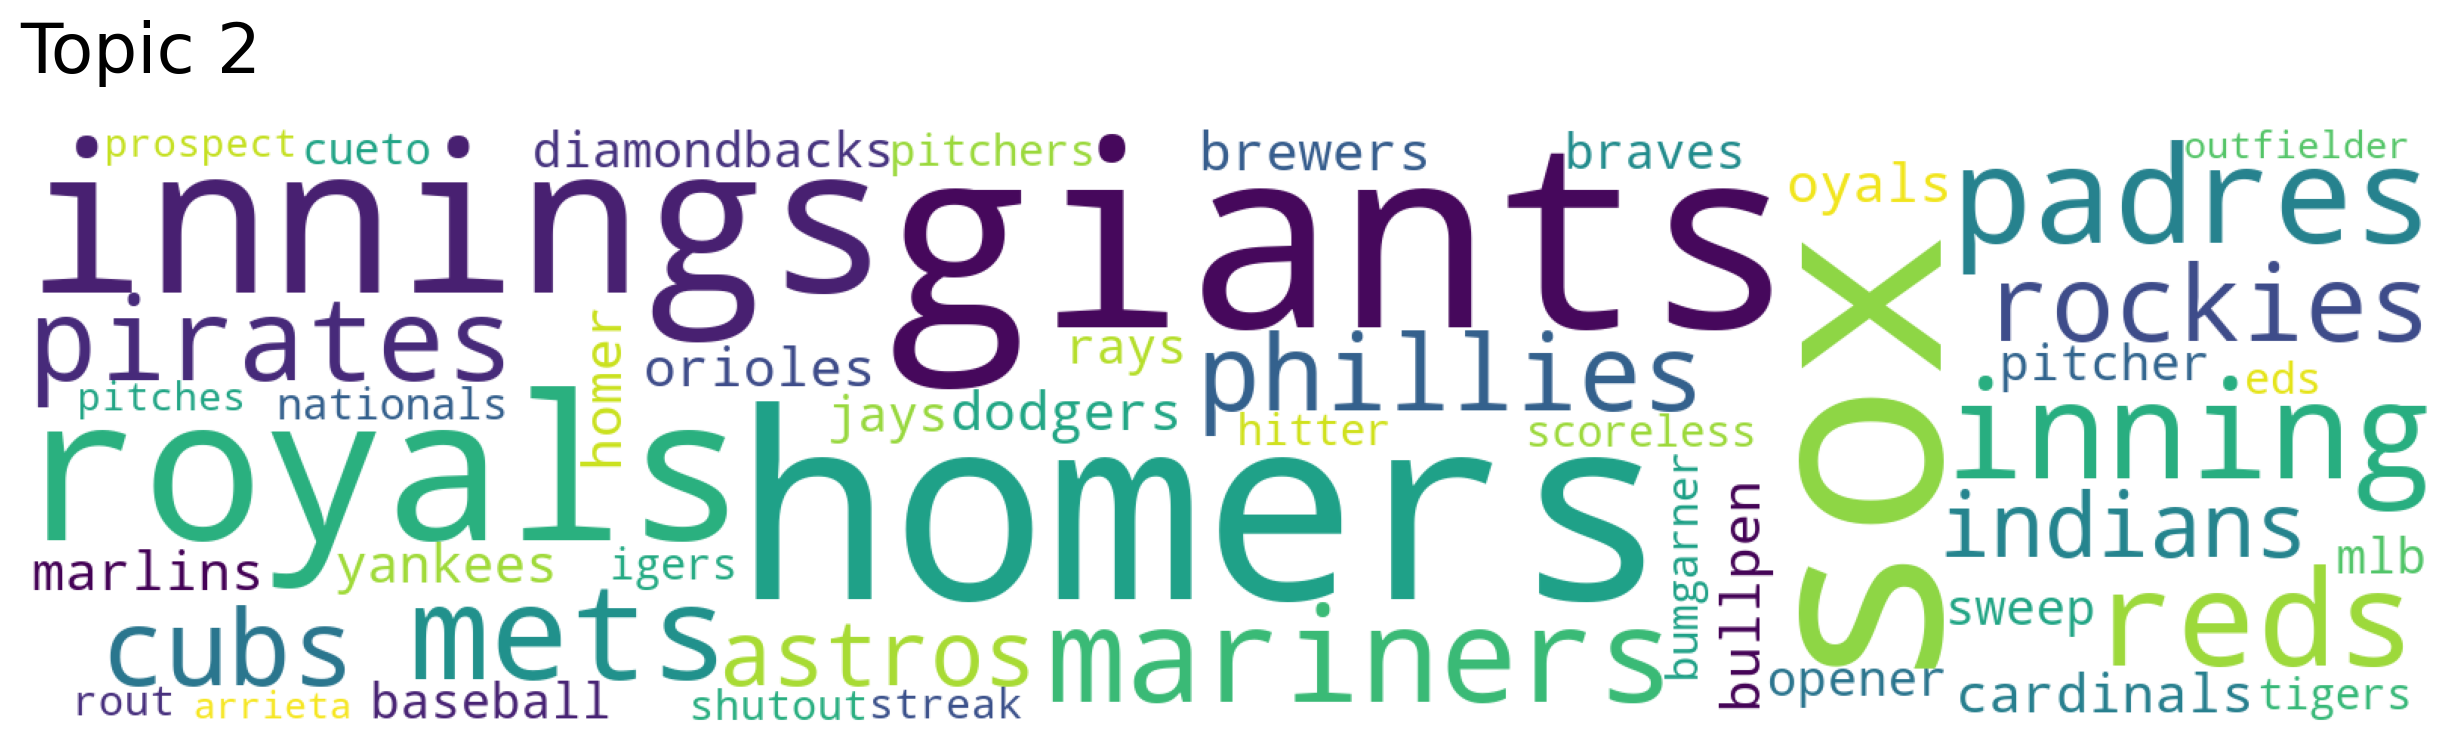

In [65]:
plt.figure()
model.generate_topic_wordcloud(2, background_color='white')
plt.savefig("../Data/report_plots/dynamic analysis/doc2vec/d2v_topic2.pdf")

### Compute Information Gain - 

#### Assign Nearest Topic

In [16]:
tweet_df['nearest_topic'] = -1

In [19]:
def find_nearest_topic(index):
    dvec = model.model.docvecs.vectors_docs[index].reshape(1, -1)
    simvec = cosine_similarity(model.topic_vectors, dvec)
    nearest_topic = np.argmax(simvec)
    return nearest_topic

In [20]:
for index in tqdm(tweet_df.index.values):
    dvec = model.model.docvecs.vectors_docs[index].reshape(1, -1)
    simvec = cosine_similarity(model.topic_vectors, dvec)
    nearest_topic = np.argmax(simvec)    
    tweet_df.iloc[index, -1] = nearest_topic

tweet_df.to_csv("../Data/bert_model_ira_with_nearest_topic.csv", index=False)

  0%|▏                                                                       | 3155/1528769 [01:28<11:55:21, 35.54it/s]


KeyboardInterrupt: 

In [ ]:
# tweet_df['nearest_topic'] = result
tweet_df.to_csv("../Data/ira_with_nearest_topic.csv", index=False)

In [38]:
tweet_df = pd.read_csv("../Data/ira_with_nearest_topic.csv")

In [39]:
# for every topic:
    # for every doc:
        # for every word:
            # p(d|w) = p(w|d) p(d)
            # p(d,w) = p(w|d) p(d)
            # p(d|w) log (p(d,w)/(p(d)p(w)))
            

In [55]:
all_topics = model.get_topics()[2]
top_n = 20
each_topic_gain_dict = {}

In [56]:
total_info_gain = 0
porter = PorterStemmer()
for each_topic in tqdm(all_topics):
    each_topic_gain = 0
    # get top 20 words for this topic
    top_n_words_before_stem = copy.deepcopy(model.get_topics()[0][each_topic][0:top_n])
    top_n_words = list(map(porter.stem, top_n_words_before_stem))
    
    # get every document belonging to that topic
    topic_documents = list(tweet_df[tweet_df['poll_choices'] == each_topic]['tweet_text'].values)
    total_words_in_topic = len(model._tokenizer(" ".join(list(
        tweet_df[tweet_df['poll_choices'] == each_topic]['tweet_text'].values))))
    
    t_doc_sum = 0
    for every_doc in topic_documents:
        total_words_in_doc = len(model._tokenizer(every_doc))
        # some junk in the document
        if total_words_in_doc == 0:
            continue
        # stem words before passing counting the frequency
        stemmed_words_in_doc = list(map(porter.stem, model._tokenizer(every_doc)))        
        word_freq_dict = Counter(stemmed_words_in_doc)
        
        t_word_sum = 0
        for t_word in top_n_words:
            p_w_given_d = word_freq_dict[t_word]/total_words_in_doc    # p(w|d)
#             print(t_word, word_freq_dict[t_word])
            if p_w_given_d > 0:
                p_w = word_freq_dict[t_word]/total_words_in_topic          # p(w)
                p_d = 1.0/len(topic_documents)      # p(d) = 1/total docs in that topic

                temp1 = (p_w_given_d * p_d)
                temp2 = math.log(p_w_given_d/p_w)
                t_word_sum += temp1 * temp2
        
        t_doc_sum += t_word_sum
    
    each_topic_gain = t_doc_sum
    each_topic_gain_dict[each_topic] = each_topic_gain
    total_info_gain += each_topic_gain

100%|████████████████████████████████████████████████████████████████████████████| 11576/11576 [08:43<00:00, 22.11it/s]


In [57]:
total_info_gain

14256.084639686038

In [42]:
total_info_gain

10091.260028264262

In [46]:
{k: v for k, v in sorted(each_topic_gain_dict.items(), key=lambda item: item[1], reverse=True)}

{12: 7.95812139476203,
 6028: 6.7591593207040965,
 2266: 4.963908857722477,
 3515: 4.611556572732388,
 3423: 4.592488815871669,
 947: 4.399266148791294,
 1049: 4.374501499534323,
 7191: 4.288528404797275,
 841: 4.26620041635499,
 9559: 4.169197228693394,
 1054: 3.9737829648533527,
 6: 3.9276571100280377,
 4638: 3.804933146136649,
 2207: 3.7957504988328137,
 2563: 3.7798726554367743,
 576: 3.7155831589121293,
 3523: 3.701498532991995,
 155: 3.658986795498022,
 3156: 3.613735831853963,
 5344: 3.605022284667816,
 7515: 3.600779191040248,
 10528: 3.5848741634812358,
 7618: 3.4905108173715944,
 1628: 3.453410176903614,
 3787: 3.4386760830981213,
 91: 3.3596771069202416,
 6436: 3.3584578599670643,
 1: 3.281419214026269,
 1312: 3.200574450181065,
 501: 3.1346484414233733,
 9657: 3.130646282074,
 7710: 3.1131908292520736,
 4867: 3.1086211052802355,
 3738: 3.0723357407572287,
 8345: 3.0706573257198575,
 2308: 3.0676546111775984,
 2542: 3.0661524960654654,
 823: 3.057827650277472,
 7313: 2.99999

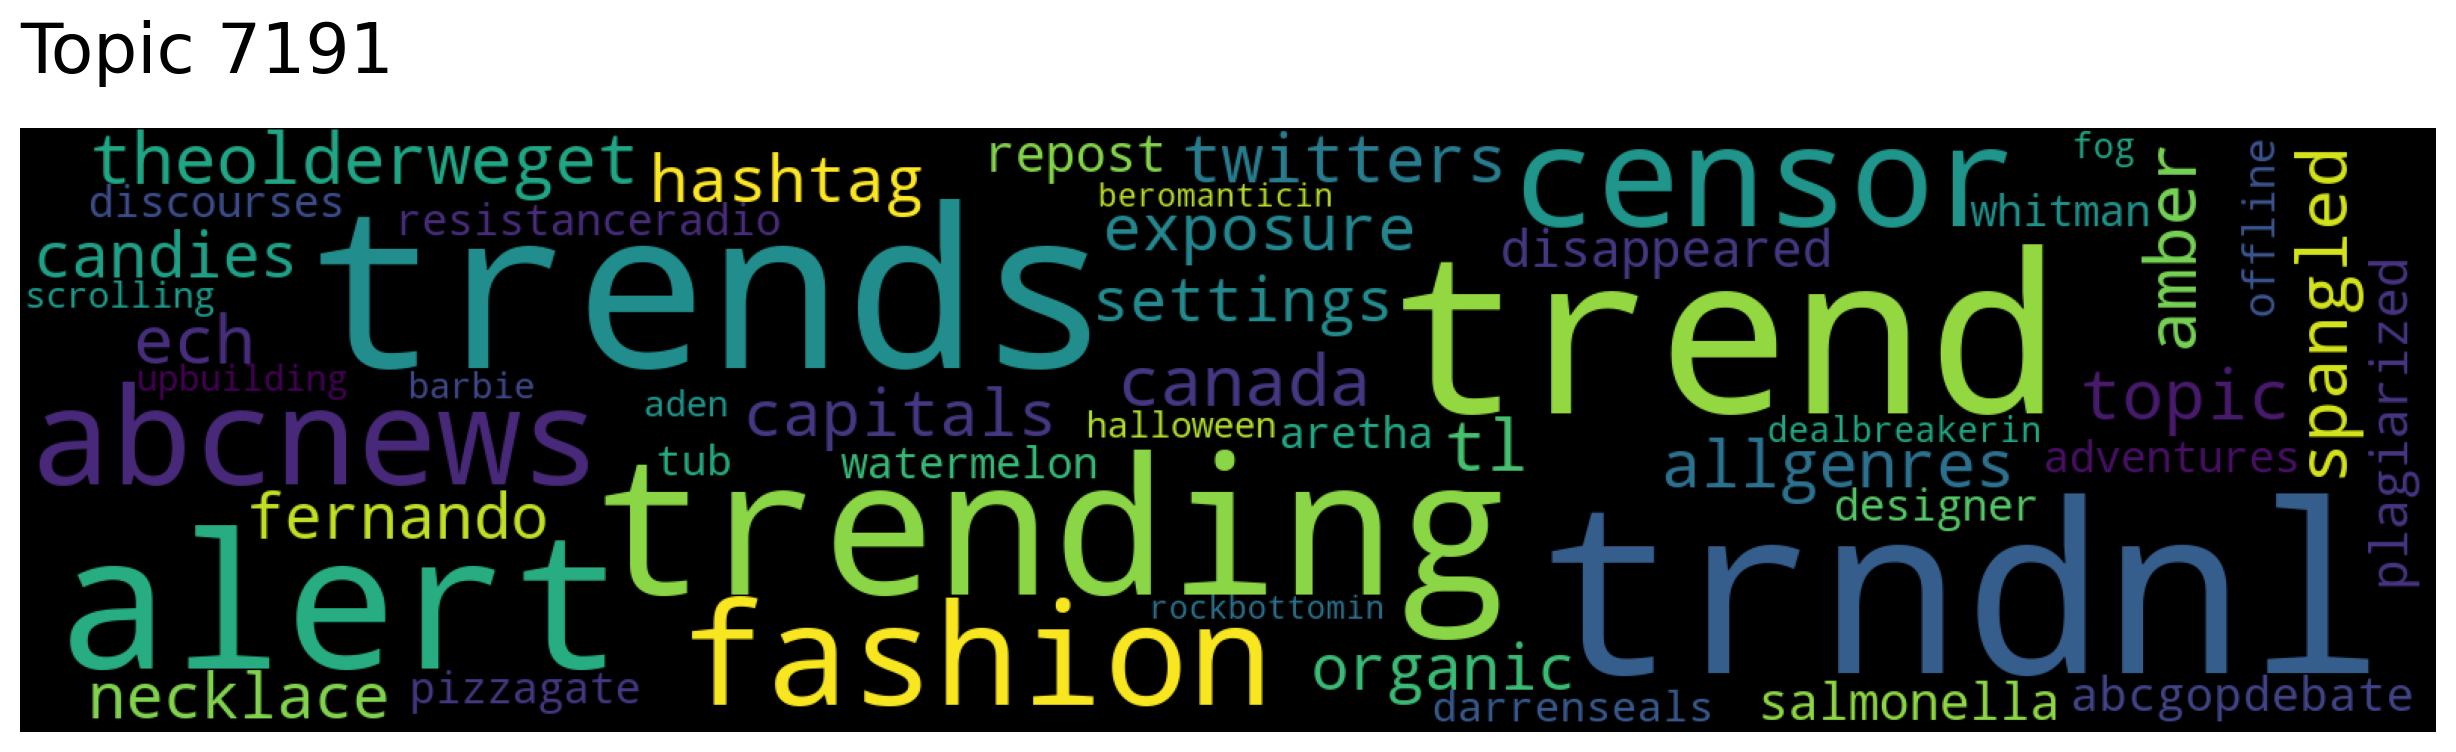

In [54]:
model.generate_topic_wordcloud(7191)

#### Reduce the topics to a 1000 topics

In [ ]:
hierarchy = model.hierarchical_topic_reduction(1000)

In [29]:
weekly_time_period = pd.date_range(start='2016-01-01', 
                                   end=str(pd.to_datetime(tweet_df['tweet_time'].max()) + timedelta(days=7)), freq='7D')

In [6]:
# first_week = tweet_df[(pd.to_datetime(tweet_df['tweet_time']) >= weekly_time_period[0]) & (pd.to_datetime(tweet_df['tweet_time']) < weekly_time_period[1])]

In [7]:
# pd.to_datetime(tweet_df['tweet_time'])

In [8]:
topics_considered = set()
dominant_topics = {}
background_topics = {}
m = 20
for i in tqdm(range(len(weekly_time_period) - 1)):
    week_df = tweet_df[(pd.to_datetime(tweet_df['tweet_time']) >= weekly_time_period[i]) & (pd.to_datetime(tweet_df['tweet_time']) < weekly_time_period[i+1])]
    
    # if you dont find any datapoints for a particular week, then continue the for-loop
    if week_df.shape[0] == 0:
        print("No documents were found for week "+ str(i) + " - " + str(weekly_time_period[i]) + "to " + 
             str(weekly_time_period[i+1]))
        
        continue
    
    weekly_docs_indexes = week_df.index.values
    weekly_docs = model.model.docvecs.vectors_docs[weekly_docs_indexes]
    total_weekly_docs = weekly_docs.shape[0]
    total_weekly_docs_considered = 0
    # dict to hold the topic number and the number of documents belonging to that topic
    topic_docnum = {}
    
    for d in weekly_docs:
        similarity_vec = cosine_similarity(model.topic_vectors, d.reshape(1,-1))
        # pick the nearest topic to this document only if the similarity score is greater than 0.2. Else, ignore the document
#         if np.max(similarity_vec) > 0.2:
        total_weekly_docs_considered += 1
        nearest_topic = np.argmax(similarity_vec)
        if nearest_topic in topic_docnum.keys():
            topic_docnum[nearest_topic] += 1
        else:
            topic_docnum[nearest_topic] = 1
    
    if total_weekly_docs - total_weekly_docs_considered > 0:
#         print("There were " + str(total_weekly_docs - total_weekly_docs_considered) + " documents for which similarity score between topics and document was lower than 0.2")
        print(str(total_weekly_docs - total_weekly_docs_considered) + " documents weren't considered out of " + str(total_weekly_docs))
    
    if topic_docnum:
        # Pick min. number of topics that constitute atleast 30% of the documents as the top-topics.. 
        # the result could be as low as 1 topic too!
        topic_docnum = {k: v for k, v in sorted(topic_docnum.items(), key=lambda item: item[1], reverse=True)}
#         print(topic_docnum)
        threshold = 0.3 # 30% 
        current_val = 0
        predominant_topics_of_the_week = list(topic_docnum.keys())[:m]
        background_topics_of_the_week = list(topic_docnum.keys())[m:]
#         predominant_topics_of_the_week = [] 
#         background_topics_of_the_week = []
        
#         for topic, doc_count in topic_docnum.items():
#             if current_val < threshold:
#                 current_val += doc_count/total_weekly_docs_considered
#                 predominant_topics_of_the_week.append(topic)
#             else:
#                 background_topics_of_the_week.append(topic)
                
#             topics_considered.add(topic)
            
        dominant_topics[i] = predominant_topics_of_the_week
        background_topics[i] = background_topics_of_the_week

100%|█████████████████████████████████████████████████████████████████████████████| 105/105 [8:02:15<00:00, 275.58s/it]


In [5]:
consistent_dominant_topics = set()
consistency_period = 2 # 2 weeks

In [6]:
# with open('../Data/consistent_dominant_topics.pickle', 'rb') as handle:
#     consistent_dominant_topics = pickle.load(handle)

In [10]:
# with open('../Data/dominant_topics.pickle', 'rb') as handle:
#     dominant_topics = pickle.load(handle)

In [12]:
# Build dominant-topic-set
dominant_topicset = set()
for week, topic_list in dominant_topics.items():
    for topic in set(topic_list):
        dominant_topicset.add(topic)
                
# Build dominant-topic-dict
dominant_topicdict = {}
for week, topic_list in dominant_topics.items():
    for topic in set(topic_list):
        if topic not in dominant_topicdict.keys():
            dominant_topicdict[topic] = [week]
        else:
            dominant_topicdict[topic].append(week)

In [13]:
# Find all the consisent dominant topics
# Find all the inconsisent yet dominant topics
for topic, weeklist in dominant_topicdict.items(): 
    for k, g in groupby(enumerate(weeklist), lambda ix: ix[0]-ix[1]):
        if len(list(map(itemgetter(1), g))) >= consistency_period:
            consistent_dominant_topics.add(topic)            
background_dominant_topics = dominant_topicset.difference(consistent_dominant_topics)

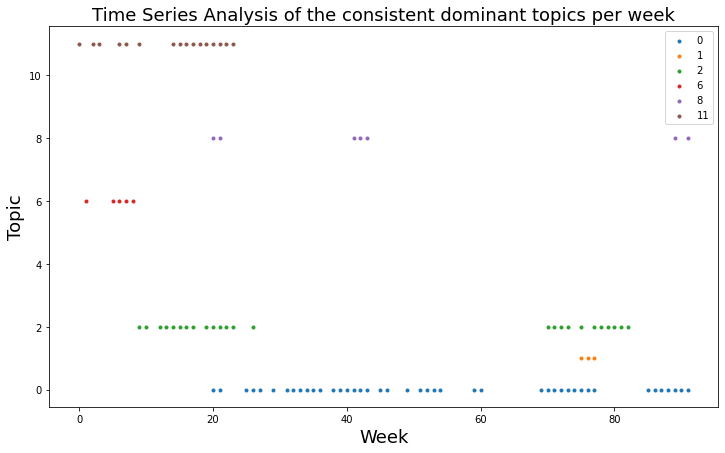

In [37]:
plt.figure(figsize = (12,7))

# for topic in set(consistent_dominant_topics):
for topic in temp_topics:
    plt.scatter(dominant_topicdict[topic], len(dominant_topicdict[topic])*[topic], marker='.')
plt.legend(temp_topics, loc='best')
plt.xlabel("Week", fontsize=18)
plt.ylabel("Topic", fontsize=18)
# plt.title("Time Series Analysis of the topics per week", fontsize=18)
plt.title("Time Series Analysis of the consistent dominant topics per week", fontsize=18)
plt.savefig("../Data/report_plots/time_series_consistent_dominant_topics.png")
# plt.show()
# plt.savefig("../Data/plots/consistent_dominant_topics.png")

In [74]:
for topic_num in consistent_dominant_topics:
    word_score_dict = dict(zip(model.topic_words[topic_num], model.topic_word_scores[topic_num]))

    plt.figure(figsize=(9, 3), dpi=200)
    plt.axis("off")
    plt.imshow(WordCloud(width=900, height=300, background_color='white').generate_from_frequencies(word_score_dict))
    plt.title("Topic " + str(topic_num), loc='left', fontsize=11, pad=20)
    plt.savefig("../Data/topic_wordclouds/consistent_dominant_topics/"+str(topic_num)+".png")
    plt.close()

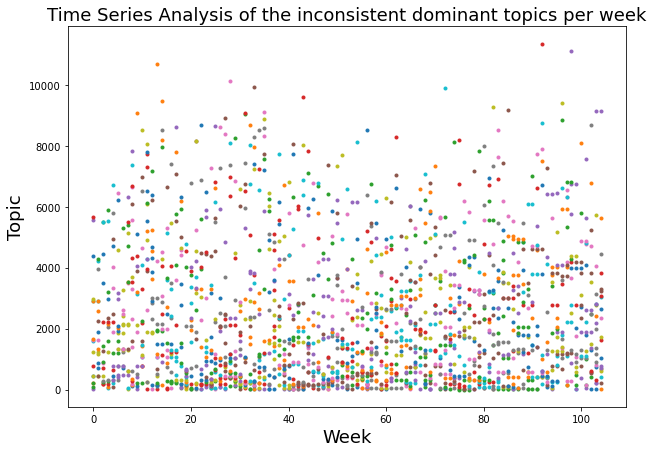

In [55]:
plt.figure(figsize = (10,7))

for topic in set(background_dominant_topics):
    plt.scatter(dominant_topicdict[topic], len(dominant_topicdict[topic])*[topic], marker='.')

plt.xlabel("Week", fontsize=18)
plt.ylabel("Topic", fontsize=18)
# plt.title("Time Series Analysis of the topics per week", fontsize=18)
plt.title("Time Series Analysis of the inconsistent dominant topics per week", fontsize=18)
# plt.show()
plt.savefig("../Data/plots/inconsistent_dominant_topics.png")

KeyboardInterrupt: 

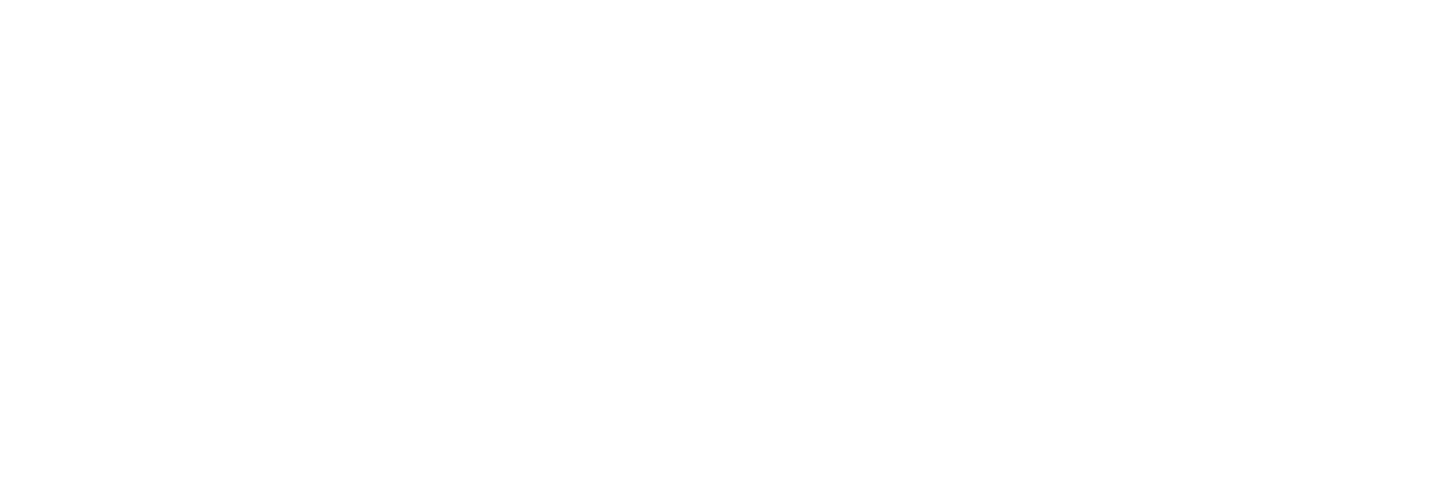

In [56]:
for topic_num in background_dominant_topics:
    word_score_dict = dict(zip(model.topic_words[topic_num], model.topic_word_scores[topic_num]))

    plt.figure(figsize=(9, 3), dpi=200)
    plt.axis("off")
    plt.imshow(WordCloud(width=900, height=300, background_color='white').generate_from_frequencies(word_score_dict))
    plt.title("Topic " + str(topic_num), loc='left', fontsize=11, pad=20)
    plt.savefig("../Data/topic_wordclouds/inconsistent_dominant_topics/"+str(topic_num)+".png")
    plt.close()

In [18]:
week_df = tweet_df[(pd.to_datetime(tweet_df['tweet_time']) >= weekly_time_period[0]) & (pd.to_datetime(tweet_df['tweet_time']) < weekly_time_period[1])]
    
weekly_docs_indexes = week_df.index.values
weekly_docs = model.model.docvecs.vectors_docs[weekly_docs_indexes]
total_weekly_docs = weekly_docs.shape[0]
total_weekly_docs_considered = 0
# dict to hold the topic number and the number of documents belonging to that topic
topic_docnum = {}

for d in tqdm(weekly_docs):
    similarity_vec = cosine_similarity(model.topic_vectors, d.reshape(1,-1))
    # pick the nearest topic to this document only if the similarity score is greater than 0.2. Else, ignore the document
#         if np.max(similarity_vec) > 0.2:
    total_weekly_docs_considered += 1
    nearest_topic = np.argmax(similarity_vec)
    if nearest_topic in topic_docnum.keys():
        topic_docnum[nearest_topic] += 1
    else:
        topic_docnum[nearest_topic] = 1

if total_weekly_docs - total_weekly_docs_considered > 0:
#         print("There were " + str(total_weekly_docs - total_weekly_docs_considered) + " documents for which similarity score between topics and document was lower than 0.2")
    print(str(total_weekly_docs - total_weekly_docs_considered) + " documents weren't considered out of " + str(total_weekly_docs))

if topic_docnum:
    # Pick min. number of topics that constitute atleast 30% of the documents as the top-topics.. 
    # the result could be as low as 1 topic too!
    topic_docnum = {k: v for k, v in sorted(topic_docnum.items(), key=lambda item: item[1], reverse=True)}
#         print(topic_docnum)
    threshold = 0.3 # 30% 
    current_val = 0
    
    predominant_topics_of_the_week = [] 
    background_topics_of_the_week = []

    for topic, doc_count in tqdm(topic_docnum.items()):
        if current_val < threshold:
            current_val += doc_count/total_weekly_docs_considered
            predominant_topics_of_the_week.append(topic)
        else:
            background_topics_of_the_week.append(topic)

        topics_considered.add(topic)
            
    dominant_topics[0] = predominant_topics_of_the_week
    background_topics[0] = background_topics_of_the_week

100%|█████████████████████████████████████████████████████████████████████████| 3926/3926 [00:00<00:00, 1309490.06it/s]


In [43]:
list(topic_docnum.keys())[:20]

[205,
 1218,
 2983,
 1582,
 441,
 768,
 5545,
 307,
 4378,
 1658,
 82,
 760,
 1639,
 11,
 2900,
 2915,
 433,
 31,
 227,
 5663]

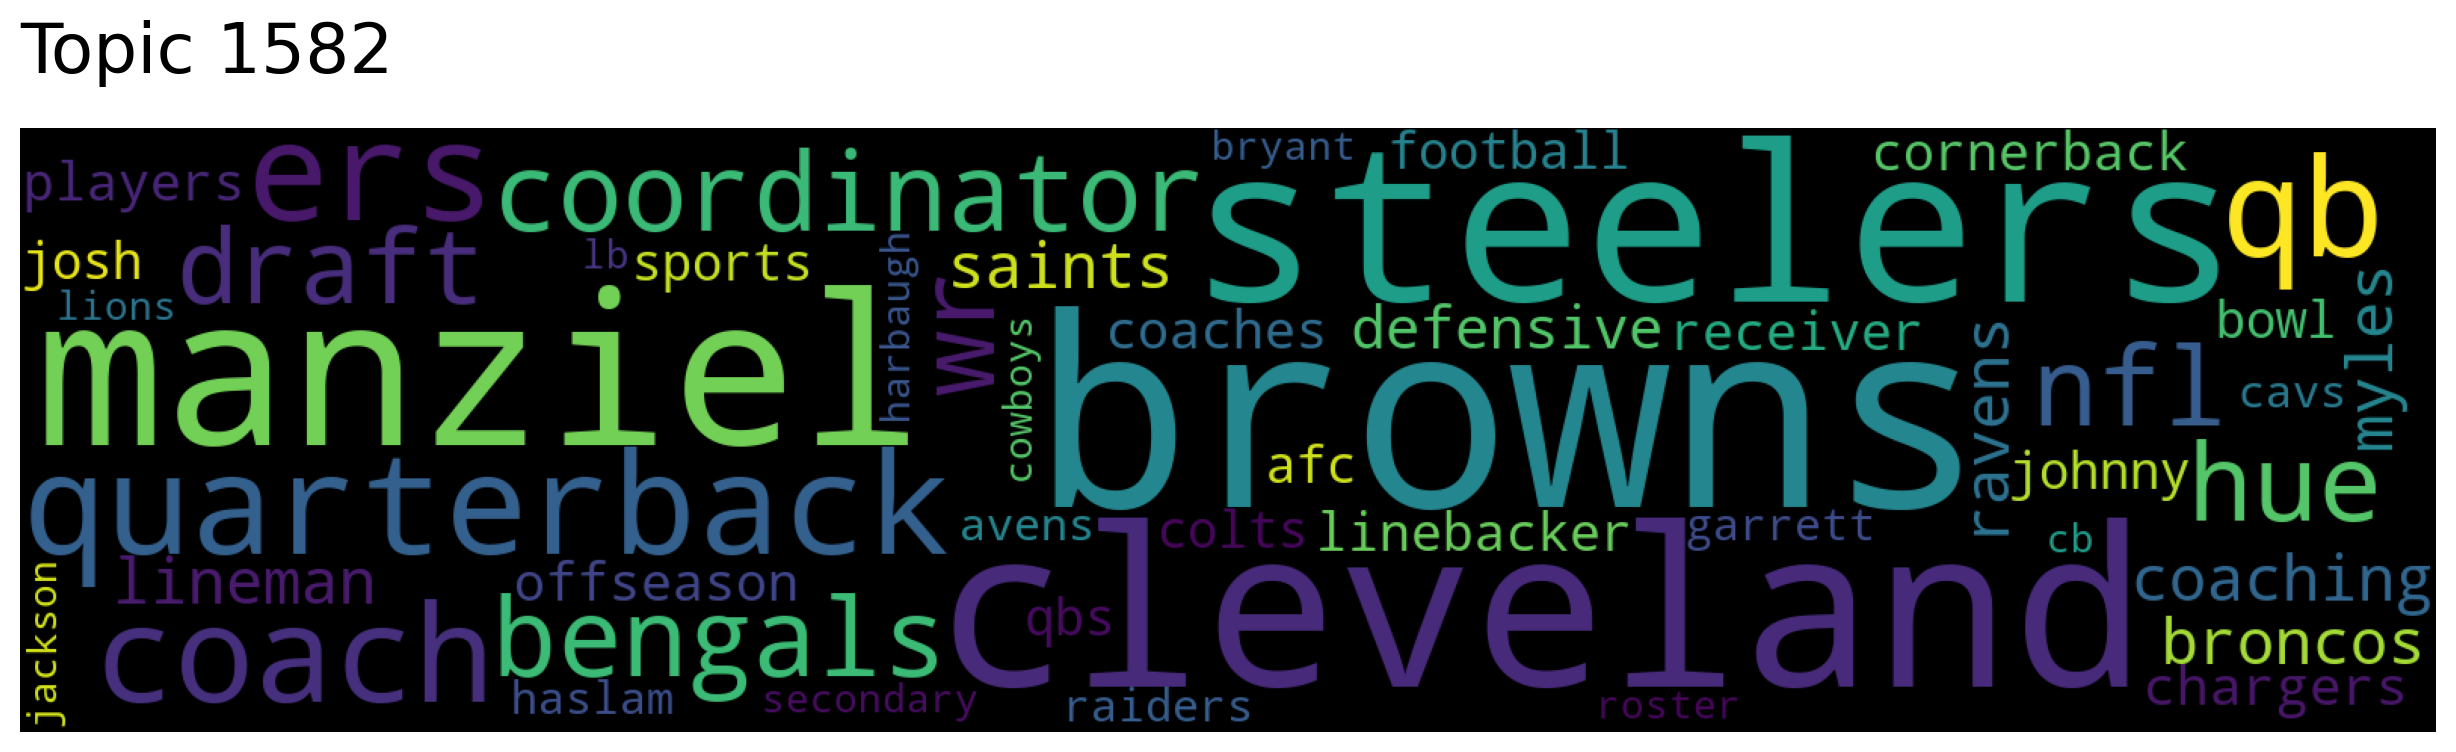

In [38]:
model.generate_topic_wordcloud(1582)
# 4378 ... too niche .. too good

In [12]:
# with open('../Data/dominant_topics.pickle', 'wb') as handle:
#     pickle.dump(dominant_topics, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [36]:
# with open('../Data/consistent_dominant_topics.pickle', 'wb') as handle:
#     pickle.dump(consistent_dominant_topics, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# with open('../Data/background_topics.pickle', 'wb') as handle:
#     pickle.dump(background_topics, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
with open('../Data/dominant_topics.pickle', 'rb') as handle:
    dominant_topics = pickle.load(handle)

In [27]:
dominant_topics

{0: [205,
  1218,
  2983,
  1582,
  441,
  768,
  5545,
  307,
  4378,
  1658,
  82,
  760,
  1639,
  11,
  2900,
  2915,
  433,
  31,
  227,
  5663],
 1: [456,
  441,
  1897,
  1160,
  6,
  4225,
  3963,
  1333,
  703,
  2915,
  4274,
  768,
  1639,
  2900,
  2577,
  884,
  307,
  1218,
  2262,
  22],
 2: [279,
  1272,
  193,
  22,
  1414,
  713,
  4455,
  3507,
  307,
  2217,
  11,
  5503,
  5487,
  768,
  441,
  169,
  17,
  908,
  874,
  244],
 3: [2052,
  49,
  2339,
  17,
  301,
  22,
  2217,
  307,
  169,
  1218,
  5882,
  81,
  271,
  1596,
  2155,
  2961,
  5522,
  768,
  11,
  3207],
 4: [71,
  309,
  17,
  1887,
  2477,
  4943,
  307,
  200,
  301,
  1188,
  785,
  4015,
  22,
  433,
  5776,
  6707,
  2217,
  4721,
  656,
  3334],
 5: [1327,
  301,
  1188,
  6,
  2978,
  1849,
  476,
  2012,
  1596,
  17,
  4576,
  2078,
  406,
  3159,
  1936,
  769,
  6209,
  785,
  6436,
  1318],
 6: [6,
  1294,
  307,
  1849,
  476,
  17,
  703,
  1316,
  2417,
  2481,
  2601,
  11,
  213

In [12]:
model.model.docvecs.vectors_docs.shape

(1528769, 300)